In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


One warehouse n stores real data(46 stores, 109 samples)
             Architecture Class  Train Loss    Dev Loss  Dev Gap %
2                   GNN_MP_real -713.143226 -625.704545  16.394826
5  GNN_MP_real_one_hot_encoding -718.679688 -626.802928  16.248062
6                  Just_In_Time -834.820901 -748.404092   0.000000
8   Symmetry_Aware_Store_Orders -717.605410 -625.578920  16.411611


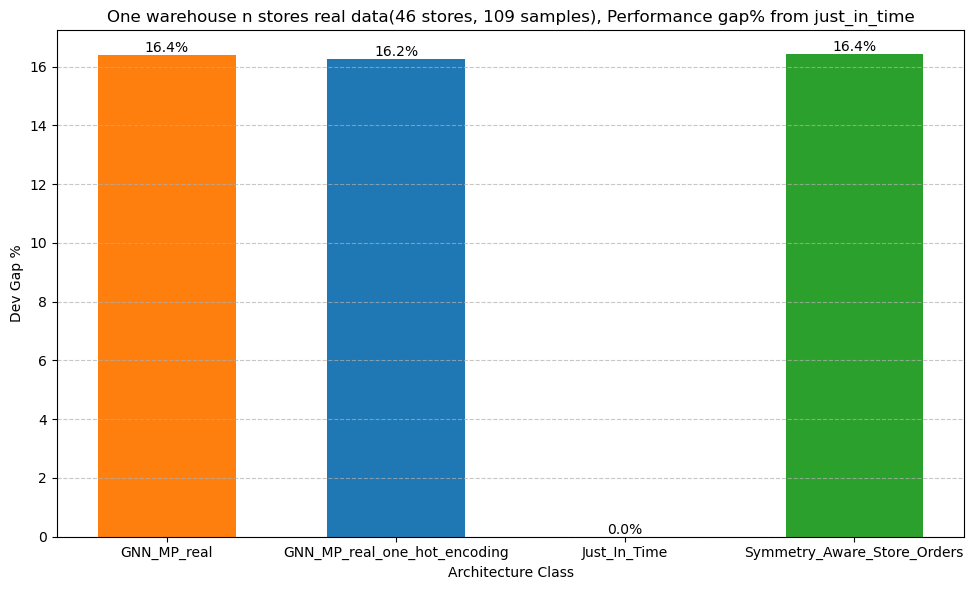

In [3]:
# Define color scheme for architecture types
color_scheme = {
    "Just_In_Time": "#9467bd",  # Purple
    "Symmetry_Aware_Store_Orders": "#2ca02c",  # Blue dotted
    "GNN_MP_real": "#ff7f0e",  # Green
    "GNN_MP_real_one_hot_encoding": "#1f77b4",  # Blue
}

linestyle_scheme = {
    "Just_In_Time": "-",
    "Symmetry_Aware_Store_Orders": ":",
    "GNN_MP_real": "--",
    "GNN_MP_real_one_hot_encoding": "-.",
}

real_path = 'generic_architecture_real'
just_in_time_paths = {
    46: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/just_in_time_real',
}
symmetry_aware_paths = {
    46: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/symmetry_aware_real',
}
gnn_mp_real_paths = {
    46: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/GNN_MP_real',
}
gnn_mp_real_one_hot_encoding_paths = {
    46: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/GNN_MP_real_one_hot_encoding',
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

results_interpretor = rri.RayResultsinterpreter()

# Just in time
df_just_in_time = results_interpretor.make_table(just_in_time_paths, {}, default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_just_in_time.insert(1, 'Architecture Class', "Just_In_Time")
df_just_in_time.insert(1, 'hyperparam_name', "just_in_time_real")

# Symmetry Aware Store Orders
df_symmetry_aware_store_orders = results_interpretor.make_table(symmetry_aware_paths, 
    {'store_orders_for_warehouse': [True], 'samples': [1,2,3]}, 
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_symmetry_aware_store_orders.insert(1, 'Architecture Class', "Symmetry_Aware_Store_Orders")
df_symmetry_aware_store_orders.insert(1, 'hyperparam_name', "symmetry_aware_real")

# GNN MP real
df_gnn_mp_real = results_interpretor.make_table(gnn_mp_real_paths, {'samples': [1,2,3]}, 
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_mp_real.insert(1, 'Architecture Class', "GNN_MP_real")
df_gnn_mp_real.insert(1, 'hyperparam_name', "GNN_MP_real")

# GNN MP real one hot encoding
df_gnn_mp_real_one_hot_encoding = results_interpretor.make_table(gnn_mp_real_one_hot_encoding_paths, {'samples': [1,2,3]}, 
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_mp_real_one_hot_encoding.insert(1, 'Architecture Class', "GNN_MP_real_one_hot_encoding")
df_gnn_mp_real_one_hot_encoding.insert(1, 'hyperparam_name', "GNN_MP_real_one_hot_encoding")

# Combine dataframes
df = pd.concat([
    df_just_in_time,
    df_symmetry_aware_store_orders,
    df_gnn_mp_real,
    df_gnn_mp_real_one_hot_encoding
])

min_dev_loss = df['Dev Loss'].min()
df['Dev Gap %'] = -((df['Dev Loss'] - min_dev_loss) / min_dev_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Dev Gap %', df.pop('Dev Gap %'))
df.drop(columns=['# of stores'], inplace=True)
df.sort_values(by=['Architecture Class'], inplace=True)
df_to_print = df.copy()
df_to_print.drop(columns=['hyperparam_name', 'Learning Rate', 'store_orders_for_warehouse', 'path', '# of runs', 'samples'], inplace=True)

# Group by Architecture Class and get row with minimum Dev Gap % for each
# First reset index to ensure proper indexing
df_to_print = df_to_print.reset_index(drop=True)
df = df.reset_index(drop=True)

# Now get minimum rows
df_to_print = df_to_print.loc[df_to_print.groupby('Architecture Class')['Dev Gap %'].idxmin()]
df = df.loc[df.groupby('Architecture Class')['Dev Gap %'].idxmin()]
print("One warehouse n stores real data(46 stores, 109 samples)")
print(df_to_print.to_string())

# Create bar plot for Dev Gap %
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for minimum values
bars = ax.bar(df['Architecture Class'], df['Dev Gap %'],
              color=[color_scheme[arch] for arch in df['Architecture Class']], 
              width=0.6)

# Add value labels for minimum values
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%',
            ha='center', va='bottom')

ax.set_xlabel('Architecture Class')
ax.set_ylabel('Dev Gap %') 
ax.set_title('One warehouse n stores real data(46 stores, 109 samples), Performance gap% from just_in_time')
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [11]:
# Function to plot training and dev loss curves for selected model
def plot_training_curves(store_underage_cost, architecture_class):
    # Get the corresponding row from df_fixed
    selected_row = df[
        (df['store_underage_cost'] == store_underage_cost) & 
        (df['Architecture Class'] == architecture_class)
    ]
    
    if len(selected_row) == 0:
        print("No model found with the specified parameters")
        return
        
    # Get the path from the selected row
    model_path = selected_row['path'].iloc[0]
    progress_path = os.path.join(model_path, 'progress.csv')
    
    if not os.path.exists(progress_path):
        print(f"Progress file not found at {progress_path}")
        return
        
    # Read and plot the training curves
    progress_df = pd.read_csv(progress_path)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(progress_df['train_loss'], label='Training Loss', color='blue')
    ax.plot(progress_df['dev_loss'], label='Dev Loss', color='red')
    
    # Add trend lines based on last 10 points
    last_10_epochs = range(len(progress_df)-10, len(progress_df))
    train_z = np.polyfit(last_10_epochs, progress_df['train_loss'].iloc[-10:], 1)
    dev_z = np.polyfit(last_10_epochs, progress_df['dev_loss'].iloc[-10:], 1)
    train_p = np.poly1d(train_z)
    dev_p = np.poly1d(dev_z)
    
    ax.plot(last_10_epochs, train_p(last_10_epochs), '--', color='black', alpha=1.0, label='Training Trend', linewidth=2)
    ax.plot(last_10_epochs, dev_p(last_10_epochs), '--', color='black', alpha=1.0, label='Dev Trend', linewidth=2)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Dev Loss Curves\nArchitecture: {architecture_class}, Store Underage Cost: {store_underage_cost}')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()
# plot_training_curves(store_underage_cost=2, architecture_class='GNN_Omit_Context_Not_Normalized')

In [3]:
def collect_data_and_plot(df, test_mode, setting_name, x_axis_value, n_stores):
    def run_main_run(row):
        try:
            cmd = [
                "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
                "main_run.py",
                test_mode, # test or test_on_dev
                setting_name,
                row['hyperparam_name'],
                row['path'],
                row['Architecture Class']
            ]
            env = {
                **os.environ,
                "MKL_THREADING_LAYER": "GNU",
                "MKL_SERVICE_FORCE_INTEL": "1"
            }
            subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
        except subprocess.CalledProcessError as e:
            print(f"Error running main_run.py for path {row['path']}: {e}")
            print(f"Error output: {e.stderr}")
        except Exception as e:
            print(f"Unexpected error running main_run.py for path {row['path']}: {e}")

    def get_file_name(row):
        return f"results/one_warehouse_real/{n_stores}/{row['Architecture Class']}/{row['store_underage_cost']}.csv"
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        futures = []
        for _, row in df.iterrows():
            file_name = get_file_name(row)
            if os.path.exists(file_name):
                continue
            while len(futures) >= 8:
                done, not_done = concurrent.futures.wait(
                    futures, 
                    return_when=concurrent.futures.FIRST_COMPLETED
                )
                futures = list(not_done)
            futures.append(executor.submit(run_main_run, row))
        concurrent.futures.wait(futures)
    
    avg_s_underage = []
    avg_s_holding = []
    avg_w_holding = []
    avg_profit = []
    for _, row in df.iterrows():
        file_name = get_file_name(row)
        data = pd.read_csv(file_name)
        n_samples = 109
        batch_size = 109
        num_batches = n_samples // batch_size
        num_steps = 50
        start_step = 16
        
        relevant_indices = []
        for batch in range(num_batches):
            batch_start = batch * batch_size * num_steps
            step_start = batch_start + start_step * batch_size
            step_end = batch_start + num_steps * batch_size
            relevant_indices.extend(range(step_start, step_end))
        
        relevant_data = data.iloc[relevant_indices]
        
        avg_s_underage.append(-relevant_data['s_underage_costs'].mean() / row['store_underage_cost'])
        avg_s_holding.append(relevant_data['s_holding_costs'].mean() / row['store_underage_cost'])
        avg_w_holding.append(relevant_data['w_holding_costs'].mean() / row['store_underage_cost'])
        avg_profit.append(-relevant_data['s_underage_costs'].sum() * n_stores - relevant_data['s_holding_costs'].sum() * n_stores - relevant_data['w_holding_costs'].sum())

    df['avg_s_underage'] = avg_s_underage
    df['avg_s_holding'] = avg_s_holding
    df['avg_w_holding'] = avg_w_holding
    df['avg_profit'] = avg_profit

    # Calculate relative profit
    just_in_time_profits = df[df['Architecture Class'] == 'Just_In_Time'].set_index('store_underage_cost')['avg_profit']
    df['relative_profit'] = df.apply(lambda row: (row['avg_profit'] / just_in_time_profits[row['store_underage_cost']]) * 100, axis=1)

    plot_data = df.pivot(index=x_axis_value, columns='Architecture Class', 
                         values=['relative_profit', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding'])
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier iteration
    titles = ['Profit % relative to Just_In_Time', 'Store Revenue / (average unit underage cost)', 'Store Holding Cost / (average unit underage cost)', 'Warehouse Holding Cost / (average unit underage cost)']
    y_values = ['relative_profit', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding']

    if x_axis_value == 'store_underage_cost':
        x_values = [2, 5, 8, 11]

    for i, (ax, title, y_value) in enumerate(zip(axes, titles, y_values)):
        for arch in df['Architecture Class'].unique():
            if arch == 'Just_In_Time':
                continue
            if arch in plot_data[y_value].columns:
                ax.plot(x_values, plot_data[y_value][arch].loc[x_values], marker='o', label=f'{arch}', 
                        color=color_scheme[arch], linestyle=linestyle_scheme[arch])
        
        ax.set_xlabel('Average unit underage cost')
        ax.set_ylabel(f'{title}')
        ax.set_title(title)
        ax.legend()
        ax.grid(True)
        ax.set_xticks(x_values)
        ax.set_xticklabels(x_values)
    
    plt.tight_layout()
    plt.show()
    return df


In [37]:

df = pd.concat([
    df_just_in_time,
    df_symmetry_aware, df_symmetry_aware_store_orders, df_symmetry_aware_omit_context, # df_symmetry_aware_normalized, df_symmetry_aware_store_orders, df_symmetry_aware_normalized_store_orders,
    df_gnn, df_gnn_store_orders, df_gnn_omit_context #df_gnn_normalized, df_gnn_store_orders, df_gnn_normalized_store_orders
])

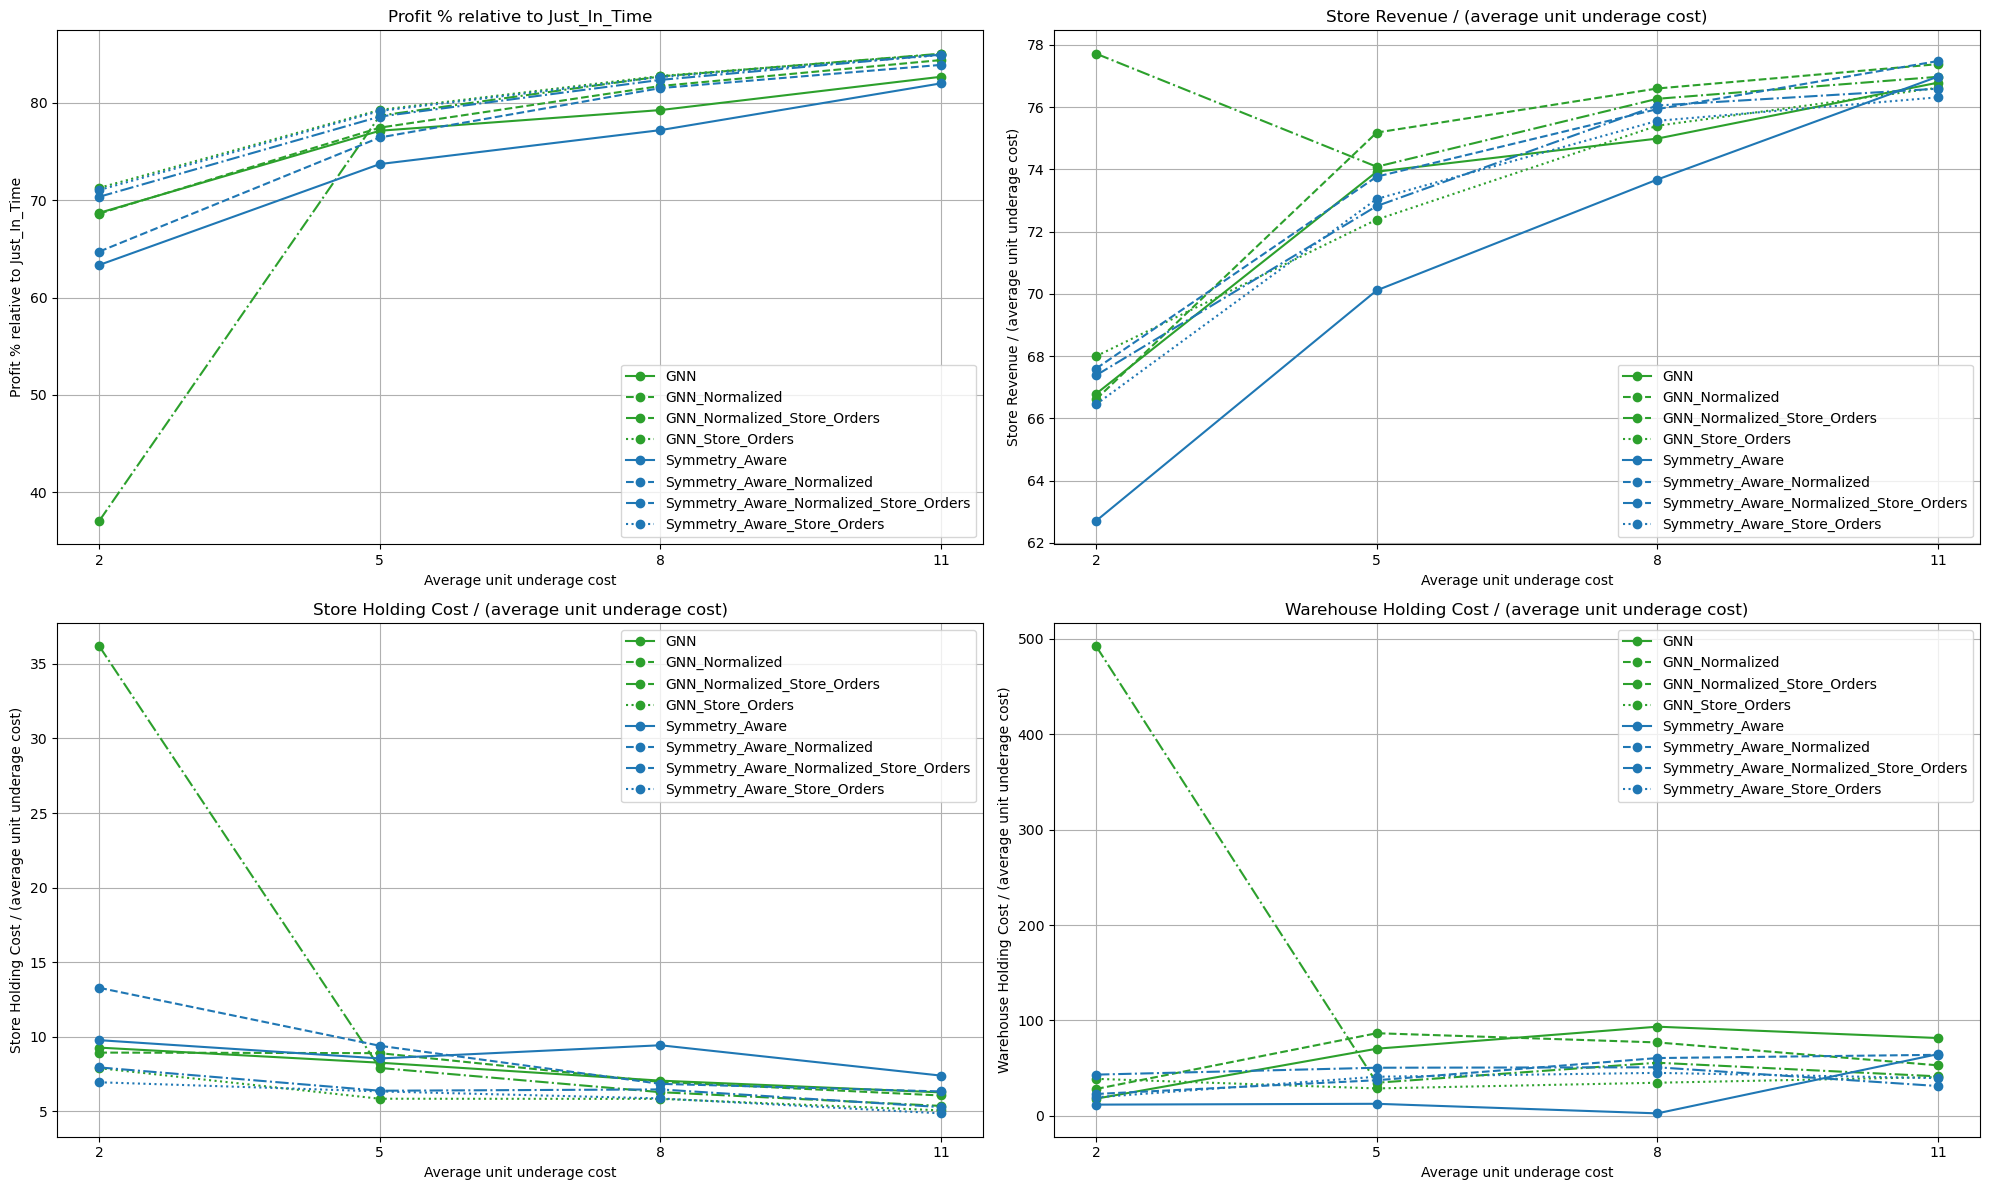

In [5]:
df_t = collect_data_and_plot(df, "test_on_dev", "one_warehouse_lost_demand_real", "store_underage_cost", 46)

In [20]:
df_t.drop(columns=['path', 'NN_name', 'hyperparam_name', 'Learning Rate'], inplace=True)

KeyError: "['NN_name'] not found in axis"

In [33]:
print(df_t.to_string())

   store_underage_cost                       Architecture Class  Train Loss    Dev Loss  Dev Gap %  avg_s_underage  avg_s_holding  avg_w_holding    avg_profit  relative_profit
0                    4                           GNN Normalized -178.865371 -163.831201  23.422011       47.663004       4.512440   5.562586e+00  1.025626e+07        76.568739
0                    4                                   Oracle -233.280130 -213.940328   0.000000       55.901950       0.000673   2.200787e-08  1.339484e+07       100.000000
0                    4  Symmetry Aware Decentralized Normalized -178.278600 -162.992594  23.813993       48.417457       5.229909   9.937769e+00  1.019960e+07        76.145733
0                    4                Symmetry Aware Normalized -179.395815 -162.114660  24.224357       48.345911       5.214215   7.953963e+00  1.021593e+07        76.267621
0                    4                       Vanilla Normalized -176.551054 -159.409785  25.488669       46.706514      